In [16]:
import time
import json
import numpy as np
import pandas as pd
from pandas import json_normalize

In [17]:
test = pd.read_csv('./pre_processed.csv')

C:\Users\iftit\AppData\Local\Temp\ipykernel_13288\251783948.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv('./pre_processed.csv')


In [3]:
def load_df(csv_path, nrows = None):
    json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,
                     #converters are dict of functions for converting values in certain columns. Keys can either be integers or column labels.
                     #json.loads() method can be used to parse a valid JSON string and convert it into a Python Dictionary.
                     #It is mainly used for deserializing native string, byte, or byte array which consists of JSON data into Python Dictionary.
                     converters = {col: json.loads for col in json_cols},                                                                         
                         dtype = {'fullVisitorId': 'str'}, # Important!!
                         nrows = nrows)
    for col in json_cols:
        # for each column, flatten data frame such that the values of a single col are spread in different cols
        # This will use subcol as names of flat_col.columns
        flat_col = json_normalize(df[col])
        # Name the columns in this flatten data frame as col.subcol for tracability
        flat_col.columns = [f"{col}.{subcol}" for subcol in flat_col.columns]
        # Drop the json_col and instead add the new flat_col
        df = df.drop(col, axis = 1).merge(flat_col, right_index = True, left_index = True)
    return df


csv_test_path = './test_v2.csv'
test = load_df(csv_test_path, nrows = None)


In [65]:
##First Rule : If total hits of a session from NON Opearting/rare countries is outlier means 1.5 IQR from Q3

import matplotlib.pyplot as plt
import json
import ast

cnt=0
sum=0
lowCountries=[]
hitWithCountry = {}
cnt = test['geoNetwork.country'].value_counts(sort=True)

for i in range(0, cnt.size):
    sum = sum + cnt[i]

#Identify the Non Operating Countries

for i in range(0, cnt.size):
    #print(f"Country Name: {cnt.index[i]} Frequency: {(cnt[i]/sum)*100}%" )
    if((cnt[i]/sum)*100 < 0.01):
        lowCountries.append(cnt.index[i]) 
    

inputCountries = test.at[0,'geoNetwork.country']

test['totals.hits'] = pd.to_numeric(test['totals.hits'])
data = test['totals.hits']
np.median(data)
upper_q = np.percentile(data, 75)
lower_q = np.percentile(data, 25)
iqr = upper_q - lower_q
upper_whisker = data[data<=upper_q+1.5*iqr].max()
lower_whisker = data[data>=lower_q-1.5*iqr].min()

for indx in range(test.index.start, test.index.stop):
    country = test.at[indx, 'geoNetwork.country']
    oneIndex = (test.at[indx,'hits'])
    hitsInfo = ast.literal_eval(oneIndex)
    #print(hitsInfo)
    if country in lowCountries:
        hit = test.at[indx, 'totals.hits']
        if int(hit) > upper_whisker:
            test.loc[indx, 'isAnomaly'] = 1
            #print(f"Index Number : {indx} Anomalous traffic Info: {country} Total Hits : {int(hit)}")
#             for ind in range(0, len(hitsInfo)):
#                 print(f"Hit Number: {hitsInfo[ind]['hitNumber']} Visited Page: {hitsInfo[ind]['appInfo']['screenName']} Keyword: {test.at[indx, 'trafficSource.keyword']}")
        #print(f"Country Name: {country} --> Total hits: {hit}")
#         if country in hitWithCountry.keys():
#             hitWithCountry[country] += 1
#         else:
#             hitWithCountry[country]=1

#newArr = test['hits'].to_numpy()


In [1]:
import ast
oneIndex = (test.at[0,'hits'])
result = ast.literal_eval(oneIndex)
#print(type(result))
for ind in range(0, len(result)):
    print(f"Hit Number: {result[ind]['hitNumber']} Visited Page: {result[ind]['appInfo']['screenName']}")

NameError: name 'test' is not defined

In [18]:
##Rule 2 : if total pageViews from a session is absurdly higher

import matplotlib.pyplot as plt
import scipy.stats as stats
sum = 0
test['totals.pageviews'] = pd.to_numeric(test['totals.pageviews'])
##Replace NaN Values with Zero
test.dropna(subset=['totals.pageviews'], inplace = True)
data = test['totals.pageviews']
upper_q = np.percentile(data, 75)
lower_q = np.percentile(data, 25)
iqr = upper_q - lower_q
upper_whisker = data[data<=upper_q+1.5*iqr].max()
lower_whisker = data[data>=lower_q-1.5*iqr].min()
lower_whisker

## Rule based on the Total PageView
for i in range(len(test)):
    pageView = test.loc[i , 'totals.pageviews']
    if pageView > upper_whisker:
        sum = sum+1
upper_whisker





KeyError: 584

In [ ]:
for i,j in zip(test.fullVisitorId.duplicated().index, test.fullVisitorId.duplicated()):
    if j == True:
        print(test.loc[i, 'fullVisitorId'])

In [48]:
sum = 0
test['totals.hits'] = pd.to_numeric(test['totals.hits'])
mean = test['totals.hits'].mean()
std = test['totals.hits'].std()
maximum = test['totals.hits'].max()

#plt.boxplot(test['totals.hits'])
#plt.xlim(xmin=0, xmax = 501)
#plt.show()
data = test['totals.hits']
np.median(data)
upper_q = np.percentile(data, 75)
lower_q = np.percentile(data, 25)
iqr = upper_q - lower_q
upper_whisker = data[data<=upper_q+1.5*iqr].max()
lower_whisker = data[data>=lower_q-1.5*iqr].min()
upper_whisker
data    

0         4
1         4
2         4
3         5
4         5
         ..
401584    3
401585    3
401586    3
401587    3
401588    3
Name: totals.hits, Length: 401589, dtype: int64

In [ ]:
## total.timeOnSite means session duration of a session
import matplotlib.pyplot as plt
sum = 0
test['totals.timeOnSite'] = pd.to_numeric(test['totals.timeOnSite'])
mean = test['totals.timeOnSite'].mean()
sDev = test['totals.timeOnSite'].std()
for i in test['totals.timeOnSite']:
    if i >= mean+2*sDev:
        sum = sum + 1
mean

In [19]:
#test['visitStartTime'] = pd.to_datetime(test['visitStartTime'], unit='s')
test = test.sort_values(by = 'visitStartTime')
test = test.reset_index(drop = True)
#print(test)
timeDiff = test['visitStartTime'].max() - test['visitStartTime'].min()
dayDiff = timeDiff / 86400
dayDiff = dayDiff.round()
print(dayDiff)
UsersPerDay = (test['fullVisitorId'].count() / dayDiff).round()
UsersPerHour = (UsersPerDay/24).round()
startTime = test.loc[0 , 'visitStartTime']
sumOfUsers = 0
userCounts=[]
for itr in range(len(test)):
    #print(test.loc[itr, 'visitStartTime'])
    if(test.loc[itr, 'visitStartTime'] > (startTime + 86400)):
        startTime = test.loc[itr, 'visitStartTime']
        userCounts.append(sumOfUsers)
        sumOfUsers = 0
    sumOfUsers = sumOfUsers+1
len(userCounts)
#test.head()

168.0


167

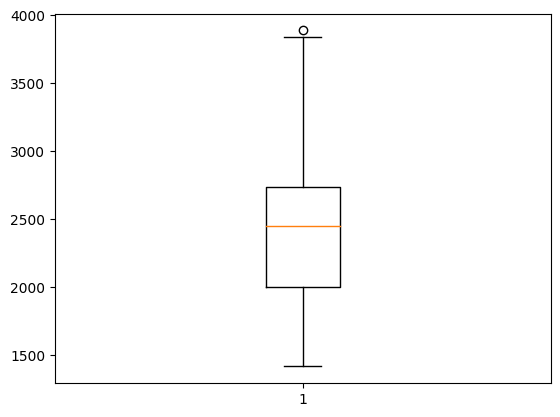

In [17]:
a = np.array(userCounts)
import matplotlib.pyplot as plt
plt.boxplot(a)
plt.show()

In [74]:
test['isAnomaly'].fillna(value = 0, inplace = True)
sum = 0
for i in range(len(test)):
    if test.loc[i, 'isAnomaly'] == 1:
        sum = sum+1
sum

53

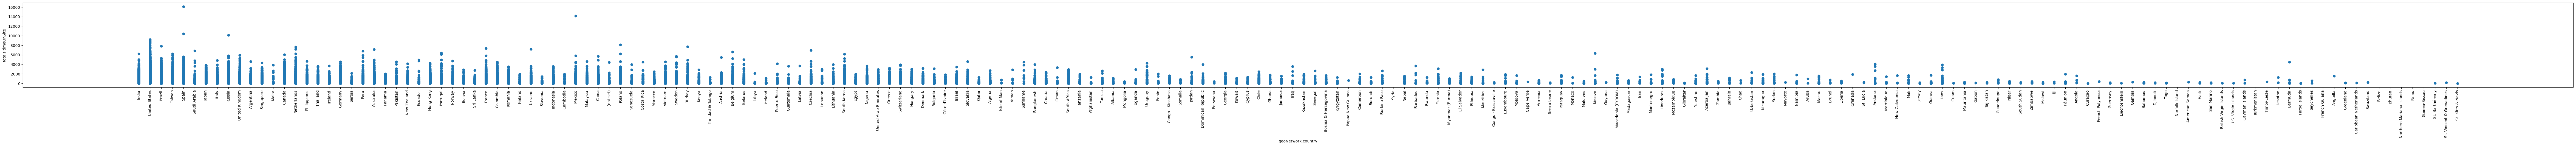

In [13]:
import matplotlib.pyplot as plt
#categories = df['Predictions'].to_numpy()
colormap = np.array(['g', 'r'])

f = plt.figure(figsize=(120, 4))
f = plt.scatter(pre_processed_df['geoNetwork.country'], pre_processed_df['totals.timeOnSite'])
f = plt.xlabel('geoNetwork.country')
f = plt.ylabel('totals.timeOnSite')
f = plt.xticks(rotation=90)
plt.show()